In [1]:
from pyntcloud import PyntCloud
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datagenerator import DataGenerator
import utils
import random
import itertools

/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


WARNING! Multiple manual measurements for QR-code: SAM-GOV-049 ../data/db/persons/c79b708e301d9c71_shaikh_1531300004131_40Aq4RZQ3gUZts74/measures/c79b708e301d9c71_measure_1531300841811_Lhp0PzvwnmlyRspG/c79b708e301d9c71_measure_1531300841811_Lhp0PzvwnmlyRspG.json
WARNING! Multiple manual measurements for QR-code: SAM-SNG-014 ../data/db/persons/f2467a1fb0c542b9_kamble_1530687006027_AVA2AqQDcVsHYrrK/measures/f2467a1fb0c542b9_measure_1531291525951_BhMYXh4Zeu9Jk7Zr/f2467a1fb0c542b9_measure_1531291525951_BhMYXh4Zeu9Jk7Zr.json
WARNING! Multiple manual measurements for QR-code: SAM-SNG-096 ../data/db/persons/f2467a1fb0c542b9_kamble_1530687464869_e6puVVsetdSpP7sH/measures/f2467a1fb0c542b9_measure_1531291761123_0ZS7kMnJLy70pe4I/f2467a1fb0c542b9_measure_1531291761123_0ZS7kMnJLy70pe4I.json
Generating...
2


In [2]:
if os.path.exists("datasetpath.txt"):
    dataset_path = open("datasetpath.txt", "r").read().replace("\n", "")
else:
    dataset_path = "../data"

data_generator = DataGenerator(dataset_path=dataset_path, input_type="voxelgrid", output_targets=["height", "weight"])

WARNING! Multiple manual measurements for QR-code: SAM-GOV-049 ../data/db/persons/c79b708e301d9c71_shaikh_1531300004131_40Aq4RZQ3gUZts74/measures/c79b708e301d9c71_measure_1531300841811_Lhp0PzvwnmlyRspG/c79b708e301d9c71_measure_1531300841811_Lhp0PzvwnmlyRspG.json
WARNING! Multiple manual measurements for QR-code: SAM-SNG-014 ../data/db/persons/f2467a1fb0c542b9_kamble_1530687006027_AVA2AqQDcVsHYrrK/measures/f2467a1fb0c542b9_measure_1531291525951_BhMYXh4Zeu9Jk7Zr/f2467a1fb0c542b9_measure_1531291525951_BhMYXh4Zeu9Jk7Zr.json
WARNING! Multiple manual measurements for QR-code: SAM-SNG-096 ../data/db/persons/f2467a1fb0c542b9_kamble_1530687464869_e6puVVsetdSpP7sH/measures/f2467a1fb0c542b9_measure_1531291761123_0ZS7kMnJLy70pe4I/f2467a1fb0c542b9_measure_1531291761123_0ZS7kMnJLy70pe4I.json


Number of samples: 50
50


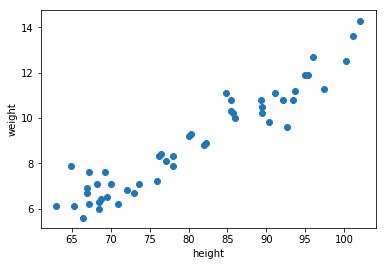

In [3]:
print("Number of samples:", len(data_generator.qrcodes_dictionary.keys()))
print(len(set(data_generator.qrcodes_dictionary.keys())))

targets = [target for key, (target, _, _) in data_generator.qrcodes_dictionary.items()]
targets = np.array(targets)

plt.scatter(targets[:,0], targets[:,1])
plt.xlabel("height")

plt.ylabel("weight")
plt.show()

Loading voxelgrid...
Rendering voxelgrid...


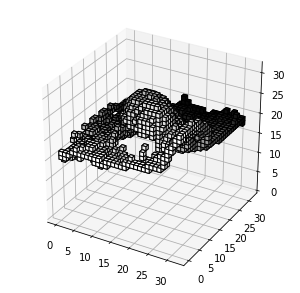

Done.


In [4]:
def render_voxelgrid(voxelgrid):
    figsize = (5, 5)
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection='3d')
    transformed_voxelgrid = np.flip(np.flip(voxelgrid, axis=2), axis=0)

    facecolors = np.zeros(transformed_voxelgrid.shape + (3,))
    for x, y, z in itertools.product(range(transformed_voxelgrid.shape[0]), range(transformed_voxelgrid.shape[1]), range(transformed_voxelgrid.shape[2])):
        color = (1.0 - y / 32)
        facecolors[x, y, z, 0] = color
        facecolors[x, y, z, 1] = color
        facecolors[x, y, z, 2] = color

    ax.voxels(transformed_voxelgrid, facecolors=facecolors, edgecolor="k")
    plt.show()
    plt.close()

    
print("Loading voxelgrid...")
voxelgrid, data = next(data_generator.generate(size=1))
print("Rendering voxelgrid...")
utils.render_voxelgrid(voxelgrid[0])

print("Done.")